# Fitting

In [1]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf
import pandas as pd

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix, IdealSPAM
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def save_spectrum(spectrum, filename):
    csr_array = np.real(spectrum.get_spectrum(is_complex=False))
    np.savetxt(filename, csr_array)

def save_heatmap(heatmap, filename):
    n = heatmap.shape[0]
    grid = np.arange(n)
    x, y = np.meshgrid(grid, grid)

    heatmap = heatmap.flatten()
    x = x.flatten()
    y = y.flatten()

    data = np.array([x, y, heatmap]).T
    np.savetxt(filename, data)


def load_data(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Load the data using pandas
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    
    # Convert the DataFrame to a NumPy array
    data_array = data.to_numpy()
    
    return data_array

import re
import numpy as np

# pre-compile the regex for performance
_exp_pat = re.compile(r'\*\^([+-]?\d+)')


def to_complex_array(obj_arr: np.ndarray) -> np.ndarray:
    """
    Convert an array of strings of the form
      - 'a+bi*I'
      - 'a-bi*I'
      - 'a*^b+ci*I'
      - 'a*^b-ci*I'
    into a numpy array of complex numbers.
    
    Parameters
    ----------
    obj_arr : np.ndarray
        Object-dtype (or string-dtype) array where each entry is a string
        like '0.5+1.2*I' or '-3.9*^-7-0.37*I'.
    
    Returns
    -------
    np.ndarray
        Array of dtype complex128 with the same shape as obj_arr.
    """
    str_arr = obj_arr.astype(str)
    
    def _convert_one(s: str) -> str:
        # 1) replace "*^b" → "eb"
        s = _exp_pat.sub(r'e\1', s)
        # 2) replace "*I" → "j"
        s = s.replace('*I', 'j')
        return s
    
    # vectorize across the array
    vect = np.vectorize(_convert_one, otypes=[str])
    j_arr = vect(str_arr)
    
    # finally cast to complex128
    return j_arr.astype(np.complex128)


## Retrieve CSR

### L = 5

In [3]:
c_max = 0.8

In [4]:
raw = load_data("data/T5_q0.dat")
csr = to_complex_array(raw)

C:\Users\krist\AppData\Local\Temp\ipykernel_31100\3837551426.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


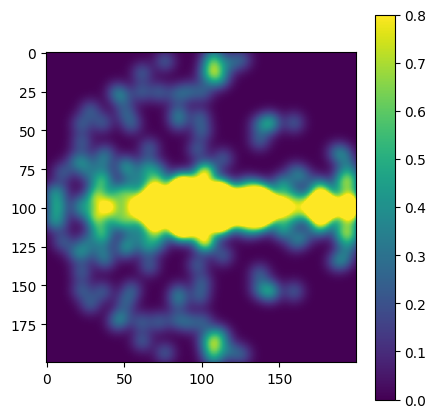

In [5]:
csr = Spectrum(csr, is_complex=True)
csr_coat = coat_spectrum(csr, sigma = 0.05, grid_size = 200)
csr_coat = csr_coat/np.max(csr_coat)

dA = 4/40000
norm = np.sum(csr_coat)*dA
csr_coat = csr_coat/norm

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_coat)
plt.colorbar()
plt.clim(0, c_max)
plt.savefig('figures/hist_integrable_L=5.png')
plt.show()

In [6]:
#save_spectrum(csr_integrable, 'book_keeping/integrable_crs_eigenvalues_L=5_retrieved.txt')
np.savetxt('book_keeping/figure2/hist_integrable_L=5.txt',csr_coat)

## L = 10

## Non-Integrable

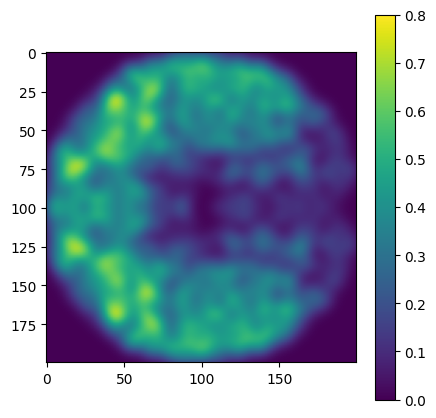

In [7]:
n = 4

model_list = pkl.load(open(f'../models/nonintegrable_model_{n}_L=10.model', 'rb'))

loss_list = []
spectrum_list = []
csr_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_list.append(csr)

csr = Spectrum(csr_list)
csr_coat = coat_spectrum(csr, sigma = 0.05, grid_size = 200)

dA = 4/40000
norm = np.sum(csr_coat)*dA
csr_coat = csr_coat/norm

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_coat)
plt.colorbar()
plt.clim(0, c_max)
plt.savefig('figures/hist_nonintegrable_L=10.png')
plt.show()

In [8]:
np.savetxt('book_keeping/figure2/hist_nonintegrable_L=10.txt', csr_coat)